# Individual Problems

Split "Category" and "Misconception" into 3 separate classification problems.

1. Classification on whether the answer was correctly answered
2. Classification on whether the right "reason" was provided
3. Classification on the misconception type

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 25/08/2025   | Martin | Created   | Created notebook for data processing | 
| 26/08/2025   | Martin | New   | Completed classification model using universal sentence encoder for question correct | 
| 16/09/2025   | Martin | New   | Completed end-to-end model: cascading results | 

# Content

* [Introduction](#introduction)
* [Universal Sentence Encoder](#universal-sentence-encoder)

# Introduction

In [2]:
%load_ext watermark

In [3]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

SEED = 43
PROJ_NAME = "math_misunderstandings"

In [4]:
wandb.login()

wandb: Currently logged in as: minimartzz to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
train = pl.read_csv("data/raw/train.csv")
test = pl.read_csv("data/raw/test.csv")
sample_submission = pl.read_csv("data/raw/sample_submission.csv")

In [6]:
train['Category'].unique()

Category
str
"""True_Neither"""
"""True_Misconception"""
"""False_Neither"""
"""True_Correct"""
"""False_Misconception"""
"""False_Correct"""


In [156]:
def data_transformation_1(pldf: pl.DataFrame, encoder=None) -> pl.DataFrame:
  """
  Correct:
    - "True": 1
    - "False": 0
  Error:
    - "Correct": 2
    - "Neither": 0
    - "Misconception": 1
  Misconception:
    - Label_encoder
  """
  pldf = pldf.with_columns(
    pl.col('Category').str.split_exact("_", 1)
    .struct.rename_fields([ "Correct", "Error" ])
    .alias("fields")
  ).unnest("fields")

  # Remap according to above encoding
  if encoder is None:
    enc = LabelEncoder()
    pldf = pldf.with_columns(
      Correct=pl.col("Correct").replace_strict(["True", "False"], [1, 0], return_dtype=pl.Int8),
      Error=pl.col("Error").replace_strict(["Correct", "Neither", "Misconception"], [2, 0, 1], return_dtype=pl.Int8),
      Misconception=pl.col("Misconception").map_batches(enc.fit_transform)
    )
    return pldf, enc
  else:
    pldf = pldf.with_columns(
      Correct=pl.col("Correct").replace_strict(["True", "False"], [1, 0], return_dtype=pl.Int8),
      Error=pl.col("Error").replace_strict(["Correct", "Neither", "Misconception"], [2, 0, 1], return_dtype=pl.Int8),
      Misconception=pl.col("Misconception").map_batches(enc.transform)
    )
    return pldf

In [97]:
train_trans, enc = data_transformation_1(train)

In [73]:
train_trans.head()

row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Correct,Error
i64,i64,str,str,str,str,i64,i8,i8
0,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""0ne third is equal to tree nin…","""True_Correct""",21,1,2
1,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 / 3 because 6 over 9 is 2 th…","""True_Correct""",21,1,2
2,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 3rd is half of 3 6th, so it …","""True_Neither""",21,1,0
3,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 goes into everything and 3 g…","""True_Neither""",21,1,0
4,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 out of every 3 isn't coloure…","""True_Correct""",21,1,2


# 

# Universal Sentence Encoder

Using Google's Universal Sentence encoder and a basic transformer architecture. 

[Link](https://www.kaggle.com/models/google/universal-sentence-encoder)

- Each set of text will have it's own encoding
- "Correct": `QuestionText` + `MC_Answer`
- "Error": `QuestionText` + `StudentExplanation`
- "Misconception":`QuestionText` + `MC_Answer` +  `StudentExplanation`

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as keras
from wandb.integration.keras import WandbMetricsLogger

In [74]:
train_trans.head()

row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Correct,Error
i64,i64,str,str,str,str,i64,i8,i8
0,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""0ne third is equal to tree nin…","""True_Correct""",21,1,2
1,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 / 3 because 6 over 9 is 2 th…","""True_Correct""",21,1,2
2,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 3rd is half of 3 6th, so it …","""True_Neither""",21,1,0
3,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 goes into everything and 3 g…","""True_Neither""",21,1,0
4,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""1 out of every 3 isn't coloure…","""True_Correct""",21,1,2


Apply the universal sentence encoder

In [25]:
embed = hub.load("models/universal_sentence_encoder_v2")

# Create samples for visualisation
sample = train_trans.sample(2, seed=SEED)
qns_sample = sample['QuestionText']
qns_embed = embed(qns_sample)

print("========= Sample Embeddings ==========")
for samp, emb in zip(qns_sample, qns_embed):
  print(f"Original Question: {samp}")
  print("")
  print(f"Output Embeddings")
  print(emb)

========= Sample Embeddings ==========
Original Question: It takes \( 3 \) people a total of \( 192 \) hours to build a wall.

How long would it take if \( 12 \) people built the same wall?

Output Embeddings
tf.Tensor(
[-6.68102205e-02 -6.10626899e-02  1.79229137e-02  4.19839323e-02
 -1.17873782e-02  5.08639403e-02  5.86139075e-02 -7.71604329e-02
  1.32026728e-02 -6.27243444e-02  6.84483647e-02 -3.29053663e-02
  4.53919359e-02  7.36617520e-02  1.81412511e-02 -1.50903361e-02
  2.54544187e-02  6.20670244e-02 -3.70359793e-02  2.04275288e-02
 -6.18070327e-02 -3.01178973e-02 -5.99907758e-03 -1.10479947e-02
 -2.91003920e-02 -1.42776025e-02 -4.32836525e-02 -3.94087518e-03
 -3.53350816e-03 -7.30098933e-02 -4.24190052e-02  2.64390949e-02
 -5.52046113e-02  2.33912617e-02  6.94109201e-02  5.10292538e-02
  2.52680648e-02 -6.61791861e-02  3.16250436e-02 -1.98846310e-02
 -3.99743393e-02  8.72335285e-02 -4.19758111e-02  7.72131979e-02
 -7.08319619e-02  2.61147581e-02 -4.04614806e-02 -4.93845455e-02


In [75]:
category = train_trans['Category']
train_split, val_split = train_test_split(train_trans, train_size=0.7, random_state=SEED, stratify=category)

train_correct = train_split.select('QuestionText', 'MC_Answer', 'Correct')
train_error = train_split.select('QuestionText', 'StudentExplanation', 'Error')
train_misconception = train_split.select('QuestionText', 'MC_Answer', 'StudentExplanation', 'Misconception')

val_correct = val_split.select('QuestionText', 'MC_Answer', 'Correct')
val_error = val_split.select('QuestionText', 'StudentExplanation', 'Error')
val_misconception = val_split.select('QuestionText', 'MC_Answer', 'StudentExplanation', 'Misconception')

FFN for Correct Answer Classification

- 0: Wrong Answer
- 1: Correct Answer

In [ ]:
# Wandb configurations
config = {
  "embed_dim": 512,
  "ffn_dim": 256,
  "dropout_rate": 0.1,
  "num_classes": 1,
  "optimizer": "adam",
  "loss": "binary_crossentropy",
}

run = wandb.init(
  project=PROJ_NAME,
  notes="Split tasks into separate classification tasks",
  tags=["baseline", "separate_tasks", "univ_sent", "correct"],
  config=config
)

In [162]:
qns_input = keras.layers.Input(shape=(config['embed_dim'], )) # Questions
ans_input = keras.layers.Input(shape=(config['embed_dim'], )) # Answers

# Questions model
x1 = keras.layers.Dense(config['embed_dim'], activation="relu")(qns_input)
x1 = keras.layers.Dropout(config['dropout_rate'])(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x1)
x1 = keras.layers.Dropout(config['dropout_rate'])(x1)
x1 = keras.layers.BatchNormalization()(x1)

# Answers model
x2 = keras.layers.Dense(config['embed_dim'], activation="relu")(ans_input)
x2 = keras.layers.Dropout(config['dropout_rate'])(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x2)
x2 = keras.layers.Dropout(config['dropout_rate'])(x2)
x2 = keras.layers.BatchNormalization()(x2)

# Combined model
x3 = keras.layers.concatenate([x1, x2])
x3 = keras.layers.Dropout(config['dropout_rate'])(x3)
x3 = keras.layers.Dense(20, activation="relu")(x3)
x3 = keras.layers.Dropout(config['dropout_rate'])(x3)
outputs = keras.layers.Dense(config['num_classes'], activation="sigmoid")(x3)

model_correct = keras.Model(inputs=[qns_input, ans_input], outputs=outputs)

model_correct.compile(
  optimizer=config['optimizer'],
  loss=config['loss'],
  metrics=['accuracy']
)
model_correct.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 512)       │    262,656 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 512)       │    262,656 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 512)       │          0 │ dense_50[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 512)       │          0 │ dense_52[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_50[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_52[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, 256)       │          0 │ dense_51[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 256)       │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_51[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_53[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 512)       │          0 │ concatenate_8[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 20)        │     10,260 │ dropout_54[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 20)        │          0 │ dense_54[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 804,393 (3.07 MB)

 Trainable params: 801,321 (3.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [163]:
train_qns_embed = embed(train_correct['QuestionText'])
train_ans_embed = embed(train_correct['MC_Answer'])
train_y = train_correct['Correct']

val_qns_embed = embed(val_correct['QuestionText'])
val_ans_embed = embed(val_correct['MC_Answer'])
val_y = val_correct['Correct']

In [164]:
model_correct.fit(
  [train_qns_embed, train_ans_embed],
  train_y,
  batch_size=32,
  epochs=10,
  validation_data=([val_qns_embed, val_ans_embed], val_y),
  # callbacks=[WandbMetricsLogger()]
)

Epoch 1/10


803/803 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9618 - loss: 0.0936 - val_accuracy: 0.9862 - val_loss: 0.0345
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9834 - loss: 0.0416 - val_accuracy: 0.9862 - val_loss: 0.0343
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9871 - loss: 0.0325 - val_accuracy: 0.9862 - val_loss: 0.0322
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9857 - loss: 0.0340 - val_accuracy: 0.9862 - val_loss: 0.0336
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9854 - loss: 0.0343 - val_accuracy: 0.9862 - val_loss: 0.0331
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9866 - loss: 0.0336 - val_accuracy: 0.9862 - val_loss: 0.0351
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9875 - loss: 0.0311 - val_accuracy: 0.9862 - val_loss: 0.0324
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9861 - loss: 0.0329 - val_accuracy: 0.9862 - val_

In [72]:
run.finish()

epoch/accuracy,▁▇█▇▆█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▁▃▃▁▁▁▁▁
epoch/val_accuracy,██████▁███
epoch/val_loss,▁▄▅█▆▂▄▃▃▃
epoch/accuracy,0.987
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.03165
epoch/val_accuracy,0.98619


In [ ]:
val_preds = model_correct.predict([val_qns_embed, val_ans_embed])
val_preds = np.where(val_preds.flatten() > 0.5, 1, 0)
val_results = val_split.with_columns(
  CorrectPrediction=val_preds,
)
val_results = val_results.with_columns(
  MissedCorrectPrediction=pl.col("CorrectPrediction") == pl.col("Correct")
)

345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


<Axes: xlabel='Category', ylabel='count'>

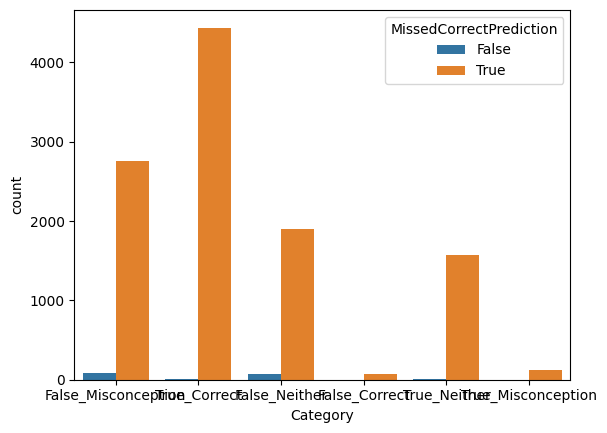

In [108]:
sns.countplot(val_results, x="Category", hue='MissedCorrectPrediction')

FFN for Error Classification. Combine the results of Correct prediction

- 1: Error in explanation
- 0: Neither
- 2: Correct explanation

In [66]:
train_correct_preds = model_correct.predict([train_qns_embed, train_ans_embed])
train_correct_preds = np.where(train_correct_preds.flatten() > 0.5, 1, 0)

val_correct_preds = model_correct.predict([val_qns_embed, val_ans_embed])
val_correct_preds = np.where(val_correct_preds.flatten() > 0.5, 1, 0)

803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


In [47]:
train_error.head()

QuestionText,StudentExplanation,Error
str,str,i8
"""\( \frac{1}{3}+\frac{2}{5}= \)""","""i think this answer is correct…",0
"""This is part of a regular poly…","""i can't see the shape and what…",-1
"""Which number is the greatest?""","""this has 6 ones and 2 tenths b…",1
"""Which number is the greatest?""","""it has to be to the nearest 10…",0
"""What fraction of the shape is …","""There is 9 triangles in the sh…",1


In [76]:
# Concatenate results of correct prediction with existing train errors dataset
train_correct_p = tf.convert_to_tensor(train_correct_preds.reshape(-1, 1), dtype=tf.float32) 
val_correct_p = tf.convert_to_tensor(val_correct_preds.reshape(-1, 1), dtype=tf.float32) 

# Create embedding sets
train_err_qns_embed = embed(train_error['QuestionText'])
train_err_qns_embed = tf.concat([train_err_qns_embed, train_correct_p], axis=1)
train_err_exp_embed = embed(train_error['StudentExplanation'])
train_err_exp_embed = tf.concat([train_err_exp_embed, train_correct_p], axis=1)
train_err_y = train_error['Error']

val_err_qns_embed = embed(val_error['QuestionText'])
val_err_qns_embed = tf.concat([val_err_qns_embed, val_correct_p], axis=1)
val_err_exp_embed = embed(val_error['StudentExplanation'])
val_err_exp_embed = tf.concat([val_err_exp_embed, val_correct_p], axis=1)
val_err_y = val_error['Error']

In [85]:
# Recreate the same model architecture
qns_input = keras.layers.Input(shape=(config['embed_dim']+1, )) # Questions
exp_input = keras.layers.Input(shape=(config['embed_dim']+1, )) # Explanations

# Questions model
x1 = keras.layers.Dense(config['embed_dim'], activation="relu")(qns_input)
x1 = keras.layers.Dropout(config['dropout_rate'])(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x1)
x1 = keras.layers.Dropout(config['dropout_rate'])(x1)
x1 = keras.layers.BatchNormalization()(x1)

# Explanations model
x2 = keras.layers.Dense(config['embed_dim'], activation="relu")(exp_input)
x2 = keras.layers.Dropout(config['dropout_rate'])(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x2)
x2 = keras.layers.Dropout(config['dropout_rate'])(x2)
x2 = keras.layers.BatchNormalization()(x2)

# Combined model
x3 = keras.layers.concatenate([x1, x2])
x3 = keras.layers.Dropout(config['dropout_rate'])(x3)
x3 = keras.layers.Dense(20, activation="relu")(x3)
x3 = keras.layers.Dropout(config['dropout_rate'])(x3)
outputs = keras.layers.Dense(3, activation="softmax")(x3)

model_error = keras.Model(inputs=[qns_input, exp_input], outputs=outputs)

model_error.compile(
  optimizer=config['optimizer'],
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy']
)
model_error.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 513)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 512)       │    263,168 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 512)       │    263,168 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 512)       │          0 │ dense_36[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 512)       │          0 │ dense_38[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_36[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_38[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 256)       │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 256)       │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_37[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_39[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 512)       │          0 │ concatenate_6[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 20)        │     10,260 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 20)        │          0 │ dense_40[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 805,459 (3.07 MB)

 Trainable params: 802,387 (3.06 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [86]:
model_error.fit(
  [train_err_qns_embed, train_err_exp_embed],
  train_err_y,
  batch_size=32,
  epochs=20,
  validation_data=([val_err_qns_embed, val_err_exp_embed], val_err_y),
  # callbacks=[WandbMetricsLogger()]
)

Epoch 1/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7158 - loss: 0.6585 - val_accuracy: 0.7750 - val_loss: 0.5106
Epoch 2/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7786 - loss: 0.5169 - val_accuracy: 0.7995 - val_loss: 0.4792
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8021 - loss: 0.4669 - val_accuracy: 0.8036 - val_loss: 0.4639
Epoch 4/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8170 - loss: 0.4396 - val_accuracy: 0.8124 - val_loss: 0.4518
Epoch 5/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8315 - loss: 0.4046 - val_accuracy: 0.8201 - val_loss: 0.4418
Epoch 6/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8472 - loss: 0.3754 - val_accuracy: 0.8142 - val_loss: 0.4559
Epoch 7/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8557 - loss: 0.3529 - val_accuracy: 0.8124 - val_loss: 0.4625
Epoch 8/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8672 - loss: 0.3277 - val_accuracy: 0.

Misconceptions model - Combination of all above features to predict a misconception. 

NOTE: For answers that are "Correct" and have no "Errors" they are always assigned 'NA' encode that rule

In [152]:
mapper = {k: v for k, v in enumerate(enc.classes_)}
mapper

{0: 'Adding_across',
 1: 'Adding_terms',
 2: 'Additive',
 3: 'Base_rate',
 4: 'Certainty',
 5: 'Definition',
 6: 'Denominator-only_change',
 7: 'Division',
 8: 'Duplication',
 9: 'Firstterm',
 10: 'FlipChange',
 11: 'Ignores_zeroes',
 12: 'Incomplete',
 13: 'Incorrect_equivalent_fraction_addition',
 14: 'Interior',
 15: 'Inverse_operation',
 16: 'Inversion',
 17: 'Irrelevant',
 18: 'Longer_is_bigger',
 19: 'Mult',
 20: 'Multiplying_by_4',
 21: 'NA',
 22: 'Not_variable',
 23: 'Positive',
 24: 'Scale',
 25: 'Shorter_is_bigger',
 26: 'Subtraction',
 27: 'SwapDividend',
 28: 'Tacking',
 29: 'Unknowable',
 30: 'WNB',
 31: 'Whole_numbers_larger',
 32: 'Wrong_Fraction',
 33: 'Wrong_Operation',
 34: 'Wrong_fraction',
 35: 'Wrong_term'}

In [141]:
# Results from model_error
train_err_preds = model_error.predict([train_err_qns_embed, train_err_exp_embed])
train_err_preds = np.argmax(train_err_preds, axis=1)

val_err_preds = model_error.predict([val_err_qns_embed, val_err_exp_embed])
val_err_preds = np.argmax(val_err_preds, axis=1)

803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step


In [150]:
# Merge both "Correct" and "Error" to misconceptions
train_misconception = train_misconception.with_columns(
  Correct=train_correct_preds,
  Error=train_err_preds
)

# Split data into training and rule-based prediction
train_actual = train_misconception.filter(
  ( pl.col("Correct") != 1 ) | ( pl.col("Error") != 2 )
)
train_rule = train_misconception.filter(
  ( pl.col("Correct") == 1 ) & ( pl.col("Error") == 2 )
)

# Create the correct and error predictions
train_correct_p = tf.convert_to_tensor(train_actual['Correct'].to_numpy().reshape(-1, 1), dtype=tf.float32) 
train_error_p = tf.convert_to_tensor(train_actual['Error'].to_numpy().reshape(-1, 1), dtype=tf.float32) 

# Create the embbedings
train_mis_qns_embed = embed(train_actual['QuestionText'])
train_mis_qns_embed = tf.concat([train_mis_qns_embed, train_correct_p, train_error_p], axis=1)
train_mis_exp_embed = embed(train_actual['StudentExplanation'])
train_mis_exp_embed = tf.concat([train_mis_exp_embed, train_correct_p, train_error_p], axis=1)
train_mis_ans_embed = embed(train_actual['MC_Answer'])
train_mis_ans_embed = tf.concat([train_mis_ans_embed, train_correct_p, train_error_p], axis=1)

train_mis_y = train_actual['Misconception']

In [154]:
# Recreate the same model architecture
qns_input = keras.layers.Input(shape=(config['embed_dim']+2, )) # Questions
exp_input = keras.layers.Input(shape=(config['embed_dim']+2, )) # Explanations
ans_input = keras.layers.Input(shape=(config['embed_dim']+2, )) # Answers

# Questions model
x1 = keras.layers.Dense(config['embed_dim'], activation="relu")(qns_input)
x1 = keras.layers.Dropout(config['dropout_rate'])(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x1)
x1 = keras.layers.Dropout(config['dropout_rate'])(x1)
x1 = keras.layers.BatchNormalization()(x1)

# Explanations model
x2 = keras.layers.Dense(config['embed_dim'], activation="relu")(exp_input)
x2 = keras.layers.Dropout(config['dropout_rate'])(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x2)
x2 = keras.layers.Dropout(config['dropout_rate'])(x2)
x2 = keras.layers.BatchNormalization()(x2)

# Answers model
x3 = keras.layers.Dense(config['embed_dim'], activation="relu")(ans_input)
x3 = keras.layers.Dropout(config['dropout_rate'])(x3)
x3 = keras.layers.BatchNormalization()(x3)
x3 = keras.layers.Dense(config['ffn_dim'], activation="relu")(x3)
x3 = keras.layers.Dropout(config['dropout_rate'])(x3)
x3 = keras.layers.BatchNormalization()(x3)

# Combined model
x4 = keras.layers.concatenate([x1, x2, x3])
x4 = keras.layers.Dropout(config['dropout_rate'])(x4)
x4 = keras.layers.Dense(20, activation="relu")(x4)
x4 = keras.layers.Dropout(config['dropout_rate'])(x4)
outputs = keras.layers.Dense(len(mapper), activation="softmax")(x4)

model_misconception = keras.Model(inputs=[qns_input, exp_input, ans_input], outputs=outputs)

model_misconception.compile(
  optimizer=config['optimizer'],
  loss="sparse_categorical_crossentropy",
  metrics=['accuracy']
)
model_misconception.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 514)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 514)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 514)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 512)       │    263,680 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 512)       │    263,680 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 512)       │    263,680 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 512)       │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 512)       │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 512)       │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_42[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_44[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_46[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 256)       │    131,328 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 256)       │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 256)       │          0 │ dense_45[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 256)       │          0 │ dense_47[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_43[0][0]

 Total params: 1,210,376 (4.62 MB)

 Trainable params: 1,205,768 (4.60 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [155]:
model_misconception.fit(
  [train_mis_qns_embed, train_mis_exp_embed, train_mis_ans_embed],
  train_mis_y,
  batch_size=32,
  epochs=10,
  # validation_data=([val_err_qns_embed, val_err_exp_embed], val_err_y),
  # callbacks=[WandbMetricsLogger()]
)

Epoch 1/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8122 - loss: 0.8323
Epoch 2/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9222 - loss: 0.2924
Epoch 3/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9203 - loss: 0.2697
Epoch 4/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9356 - loss: 0.2213
Epoch 5/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9397 - loss: 0.1967
Epoch 6/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9377 - loss: 0.1981
Epoch 7/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9420 - loss: 0.1903
Epoch 8/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9514 - loss: 0.1604
Epoch 9/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9431 - loss: 0.1800
Epoch 10/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9479 - loss: 0.1586


Make prediction on sample data

In [158]:
test.head()

row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
i64,i64,str,str,str
36696,31772,"""What fraction of the shape is …","""\( \frac{1}{3} \)""","""I think that 1/3 is the answer…"
36697,31772,"""What fraction of the shape is …","""\( \frac{3}{6} \)""","""i think this answer is because…"
36698,32835,"""Which number is the greatest?""","""\( 6.2 \)""","""because the 2 makes it higher …"


In [159]:
# Extract all embeddings
row_id = test['row_id']

test_qns_embed = embed(test['QuestionText'])
test_ans_embed = embed(test['MC_Answer'])
test_exp_embed = embed(test['StudentExplanation'])

In [166]:
# Predict Correct
test_correct = model_correct.predict([test_qns_embed, test_ans_embed])
test_correct = np.where(test_correct.flatten() > 0.5, 1, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [16]:
%watermark

Last updated: 2025-08-26T18:23:33.572200+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

